In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import requests
import tensorflow as tf
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Bidirectional,
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, GRU)


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

import pickle

import os
# pandarallel.initialize()

In [ ]:
# read data_processed.csv
data_path = '/content/drive/MyDrive/Colab Notebooks/BT5153/Data/'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BT5153/Data/Data_processed_reduced_v4.csv',encoding= 'unicode_escape')
df.shape

(18680, 11)

In [ ]:
# add img paths
df['img_path'] = df.img_id.apply(lambda x: '/content/drive/MyDrive/Colab Notebooks/BT5153/Data/Pict/' + str(x) + '.jpg')

In [ ]:
# padding 'ss' and 'ee' to the string to mark the begining and end
df['Description'] = df['Description'].apply(lambda x: 'ss '+ x + ' ee' )
df['Description'] = df['Description'].apply(lambda x: x.lower())

In [ ]:
#  build vocabulary using glove and vectorize the text
temp = []
for des in df.Description.values:
  temp.extend(des.split())
temp.append('@')

vocabulary = list(set(temp))
max_tokens = len(vocabulary)

print ("max token length : {}".format(max_tokens))
output_sequence_length=62
vectorizer = TextVectorization(max_tokens=max_tokens + 1, output_sequence_length=output_sequence_length, standardize=None)
# text_ds = df.Description.values
vectorizer.adapt(temp) 
voc = vectorizer.get_vocabulary()
print ("voc length : {}".format(len(voc)))
# del voc[1]
word_index = dict(zip(voc, range(len(voc))))
index_word = dict(zip(range(len(voc)), voc))
embeddings_index = {}
with open(data_path + "glove.6B.50d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) 
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print ("Embeding matrix shape : {}".format(embedding_matrix.shape))

max token length : 8922
voc length : 8923
Found 400000 word vectors.
Converted 8364 words (559 misses)
Embeding matrix shape : (8923, 50)


In [ ]:
# load image and preprocess to the format compatible to inception_v3
import cv2
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img

In [ ]:
# define InceptionV3 image feature extraction model 
image_model = tf.keras.applications.InceptionV3(include_top=True,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
import numpy as np

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])


  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)
def scaled_dot_product_attention(q, k, v, mask):
  

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

 
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  


  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights 

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x,batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)



  def call(self, x, enc_output, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output,  
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, 
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, max_len,num_heads, dff,  
               target_vocab_size,  pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = tf.keras.layers.Dense(d_model*max_len)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size,activation='softmax')
    self.max_len = max_len
    self.d_model = d_model

  def call(self, inp, tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    # combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
    enc_output = tf.reshape(enc_output,(-1,self.max_len,self.d_model))
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, look_ahead_mask,  dec_target_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)


    return final_output

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 2048)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer (Transformer)       (None, None, 8923)   7585445     input_2[0][0]                    
                                                                 input_3[0][0]                    
Total params: 7,585,445
Trainable params: 7,139,295
Non-trainable params: 446,150
__________________________________________________________________________________________________


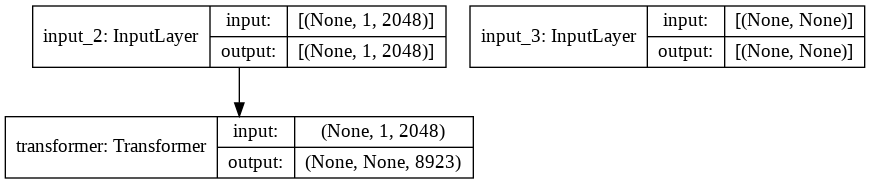

In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
num_layers = 6
dff=512
d_model=50
num_heads = 5
dropout_rate = 0.1
target_vocab_size = len(voc)
maximum_position_encoding=61
max_len=61
input1 = tf.keras.layers.Input(shape=(1,2048))
input2 = tf.keras.layers.Input(shape=(None,))
transformer = Transformer(num_layers, d_model,max_len, num_heads, dff, target_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

outputs = transformer(input1, input2)

caption_model = Model(inputs=[input1, input2], outputs=outputs)
# Checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/BT5153/Codes/Transformer_HJ/checkpoint/checkpoint5.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Early Stopping
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True, mode='min')

caption_model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=['accuracy'])

caption_model.summary()
plot_model(caption_model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
class Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, df, batch_size) :
    self.paths = df.img_path.values
    self.descriptions = df.description.values
    self.batch_size = batch_size  
    # self.on_epoch_end()
    
  def __len__(self) :
    return (np.ceil(len(self.paths) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    images = np.array([load_image(path) for path in self.paths[idx * self.batch_size : (idx+1) * self.batch_size]])
    image_features = image_features_extract_model(images)
    image_features = tf.reshape(image_features,
                              (image_features.shape[0], -1,image_features.shape[1]))
   
    texts = np.array(self.descriptions[idx * self.batch_size : (idx+1) * self.batch_size])
    texts = vectorizer(texts)
    x2 = texts[:,:-1]
    y = texts[:,1:]
    return [image_features,x2], y 

df_train = df.sample(frac=0.8, random_state=123)
df_validation = df.loc[~df.index.isin(df_train.index)]
df_train = df_train.reset_index()
df_validation = df_validation.reset_index()
print ("train size : ", df_train.shape[0])
print ("validation size : ", df_validation.shape[0])
BATCH_SIZE = 20
train_generator = Generator(df_train, BATCH_SIZE)
validation_generator = Generator(df_validation, BATCH_SIZE)

train size :  14944
validation size :  3736


**Load Model Weights**

In [ ]:
my_filepath = '/content/drive/MyDrive/Colab Notebooks/BT5153/Codes/Transformer_HJ/checkpoint/checkpoint5.ckpt'
# caption_model.save_weights(my_filepath)
caption_model.load_weights(my_filepath)

**Generate captions from trained model**

In [ ]:
def generateCaption_beam(photo_url, beam_index=2):
    photo = load_image(photo_url)
    photo = tf.reshape(photo,(1,photo.shape[0],photo.shape[1],photo.shape[2]))
    photo = image_features_extract_model(photo)
    photo = tf.reshape(photo, (1, 1, 2048))

    start = [word_index["ss"]]
    log_prob = 0.0
    start_word = [[start, log_prob]]
    
    for i in range(61):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_len, padding='post')
            yhat = caption_model.predict([photo, sequence], verbose = 0)
            yhat = yhat.reshape(-1, max_tokens+1)
            word_preds = np.argsort(yhat, axis=1)[:, -beam_index:][i, :]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(yhat[i, :][w])
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities (higher log prob, better)
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [index_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'ee':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
import time
temp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/val_transformer2_beam.csv', index_col='img_id')
temp_df = temp_df[temp_df.predicted_caption.isna()]

counter = 1
for id in temp_df.index:
  start = time.time()
  final_beam = generateCaption_beam(temp_df[temp_df.index == id].img_path.values[0], 2)
  val_transformer2_beam.loc[id, 'predicted_caption'] = final_beam
  val_transformer2_beam.to_csv('/content/drive/MyDrive/Colab Notebooks/val_transformer2_beam.csv')
  end = time.time()
  print("Processed {}/{}, time elapsed: {:.2f} seconds".format(counter, len(temp_df), end-start))
  counter += 1

Processed 1/854, time elapsed: 66.02 seconds
Processed 2/854, time elapsed: 19.41 seconds
Processed 3/854, time elapsed: 19.79 seconds
Processed 4/854, time elapsed: 15.74 seconds
Processed 5/854, time elapsed: 13.12 seconds
Processed 6/854, time elapsed: 14.11 seconds
Processed 7/854, time elapsed: 13.23 seconds
Processed 8/854, time elapsed: 13.40 seconds
Processed 9/854, time elapsed: 13.90 seconds
Processed 10/854, time elapsed: 13.12 seconds
Processed 11/854, time elapsed: 13.67 seconds
Processed 12/854, time elapsed: 13.79 seconds
Processed 13/854, time elapsed: 13.41 seconds
Processed 14/854, time elapsed: 13.38 seconds
Processed 15/854, time elapsed: 13.87 seconds
Processed 16/854, time elapsed: 12.86 seconds
Processed 17/854, time elapsed: 13.30 seconds
Processed 18/854, time elapsed: 13.48 seconds
Processed 19/854, time elapsed: 13.25 seconds
Processed 20/854, time elapsed: 12.77 seconds
Processed 21/854, time elapsed: 12.56 seconds
Processed 22/854, time elapsed: 12.80 secon

In [ ]:
# calculate bleu score

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score(df):
  bleu1=[]
  bleu2 =[]
  bleu3 = []
  bleu4=[]
  real_cap=df.real_caption.apply(lambda x: x.split()[:32] if len(x.split())>32 else x.split() )
  pred_cap=df.predicted_caption

  for i in range(len(df)):
    bleu1.append(sentence_bleu([real_cap.iloc[i]],pred_cap.iloc[i].split(),weights=(1,0,0,0),smoothing_function=SmoothingFunction().method1))
    bleu2.append(sentence_bleu([real_cap.iloc[i]],pred_cap.iloc[i].split(),weights=(0.5,0.5,0,0),smoothing_function=SmoothingFunction().method1))
    bleu3.append(sentence_bleu([real_cap.iloc[i]],pred_cap.iloc[i].split(),weights=(0.3,0.3,0.3,0),smoothing_function=SmoothingFunction().method1))
    bleu4.append(sentence_bleu([real_cap.iloc[i]],pred_cap.iloc[i].split(),weights=(0.25,0.25,0.25,0.25),smoothing_function=SmoothingFunction().method1))
  df['bleu_1']= bleu1
  df['bleu_2']= bleu2
  df['bleu_3']= bleu3
  df['bleu_4']= bleu4
  return df

  

In [ ]:
val_transformer2_beam = bleu_score(val_transformer2_beam)

In [ ]:
val_transformer2_beam.to_csv('/content/drive/MyDrive/Colab Notebooks/val_transformer2_beam.csv')